# Исследование качества рекламы и причин возникновения убытков

В рекламу развлекательного приложения Procrastinate Pro+ было вложено много капитала, однако последние несколько месяцев компания терпит убытки. Необходимо разобраться с причинами возникновения убытков.

В нашем распоряжении три таблицы: с данными о посещениях серверов, с данными о покупках и с рекламными расходами за период с 1 мая по 27 октября 2019 года.

## Цели

* Определить причину убытков.

## План работы

* Загрузить данные и провести предобработку
* Задать функции, определяющие значения метрик
* Провести исследовательский анализ данных, составить профили пользователей, определить какие из них приносят больше всего дохода, и какие рекламные источники приводят больше всего пользователей.
* Проанализировать расходы на маркетинг
* Оценить окупаемость рекламы

### Загрузите данные и подготовьте их к анализу

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import numpy as np

In [ ]:
try:
    visits_info = pd.read_csv('/datasets/visits_info_short.csv')
    orders_info = pd.read_csv('/datasets/orders_info_short.csv')
    costs_info = pd.read_csv('/datasets/costs_info_short.csv')
except:
    print('Не удалось открыть файл')

In [ ]:
display(visits_info.head(5))
visits_info.info()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [ ]:
display(orders_info.head(5))
orders_info.info()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [ ]:
display(costs_info.head(5))
costs_info.info()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Дано три таблицы с данными о посещениях, покупках и рекламных расходах: visits_info, orders_info, costs_info.

В таблице visits_info есть id, страна, тип устройства пользователей, а также идентификатор источника перехода и дата и время начала и окончания сессии. Всего 309901 строка, все данные, кроме id, типа object, id - типа int.

В таблице orders_info данные с id пользователей, датой и временем покупки, а также суммой заказа. Данные с id типа int, с датой и временем покупки типа object, с суммой заказа - float.

В таблице costs_info хранятся данные о дате проведения рекламной кампании, идентификаторе рекламного источника, расходах на данную кампанию. Первые два столбца типа object, последний - типа float. Всего в таблице 1800 строк.

In [ ]:
visits_info = visits_info.rename(columns={'User Id':'user_id','Region':'region','Device':'device','Channel':'channel','Session Start':'session_start',\
                            'Session End':'session_end'})

orders_info = orders_info.rename(columns={'User Id':'user_id','Event Dt':'event_dt','Revenue':'revenue'})

costs_info = costs_info.rename(columns={'Channel':'channel'})


display(visits_info.head(5))

display(orders_info.head(5))

costs_info.head(5)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [ ]:
visits_info['session_start'] = pd.to_datetime(visits_info['session_start'])

visits_info['session_end'] = pd.to_datetime(visits_info['session_end'])

orders_info['event_dt'] = pd.to_datetime(orders_info['event_dt']).dt.date

costs_info['dt'] = pd.to_datetime(costs_info['dt']).dt.date

In [ ]:
print(visits_info.isnull().sum())

print(orders_info.isnull().sum())

print(costs_info.isnull().sum())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64
user_id     0
event_dt    0
revenue     0
dtype: int64
dt         0
channel    0
costs      0
dtype: int64


In [ ]:
print(visits_info.duplicated().sum())

print(orders_info.duplicated().sum())

print(costs_info.duplicated().sum())

0
2
0


In [ ]:
orders_info = orders_info.drop_duplicates()
orders_info = orders_info.reset_index(drop=True)

orders_info.duplicated().sum()

0

Пропусков нет, дубликатов всего два в таблице с информацией о заказах, поэтому можно удалить без искажений данных.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Функция для определения профилей пользователей, в которых будут храниться данные о пользователях.

In [ ]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):


    profiles = (sessions.sort_values(by=['user_id', 'session_start']).groupby('user_id').\
                agg({'session_start': 'first','channel': 'first','device': 'first','region': 'first',}).\
                rename(columns={'session_start': 'first_ts'}).reset_index())

    profiles['dt'] = profiles['first_ts'].dt.date

    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(events.query('event_name == @event')['user_id'].unique())
    new_users = (profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'unique_users'})\
        .reset_index())

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']],on=['dt', 'channel'],how='left')

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Функция для расчета удержания пользователей.

In [ ]:
def get_retention(profiles, sessions, observation_days, horizon_days, dimensions = [], ignore_horizon = False):

    dimensions = ['payer'] + dimensions

    max_date = observation_days
    if not ignore_horizon:
        max_date = observation_days - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @max_date')

    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days

    def group_by_dimensions(df, dimensions, horizon_days):
        result = df.pivot_table(index = dimensions, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')
        cohort_sizes = df.groupby(dimensions).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'})
        result = cohort_sizes.merge(result, on = dimensions, how = 'left').fillna(0)
        result = result.div(result['cohort_size'], axis = 0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time


Функция для расчета конверсии.

In [ ]:
def get_conversion(profiles,purchases,observation_days,horizon_days,dimensions=[],ignore_horizon=False):
    max_date = observation_days
    if not ignore_horizon:
        max_date = observation_days - timedelta(days=horizon_days-1)

    result_raw = profiles.query('dt <= @max_date')

    first_purchases = purchases.sort_values(by=['user_id','event_dt']).groupby('user_id').\
    agg({'event_dt':'first'}).reset_index()

    result_raw = result_raw.merge(first_purchases[['user_id','event_dt']],on='user_id',how='left')

    result_raw['lifetime'] = (result_raw['event_dt']- result_raw['first_ts'].dt.date).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'all_users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(data,dimensions,horizon_days):
        result = data.pivot_table(index=dimensions,columns='lifetime',values='user_id',aggfunc='nunique')
        result = result.fillna(0).cumsum(axis=1)
        cohort_size = data.groupby(dimensions).agg({'user_id':'nunique'}).rename(columns={'user_id':'cohort_size'})
        result = cohort_size.merge(result,on=dimensions,how='left').fillna(0)
        result = result.div(result['cohort_size'],axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_size
        return result

    result_grouped = group_by_dimensions(result_raw,dimensions,horizon_days)

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time = group_by_dimensions(result_raw,dimensions+['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time



Функция для расчета LTV, суммы денег, которую один клиент в среднем приносит со всех своих покупок, а также ROI, коэффициент окупаемости рекламы.

In [ ]:
def get_ltv(profiles,purchases,observation_days,horizon_days,dimensions=[],ignore_horizon=False):
    max_date = observation_days
    if not ignore_horizon:
        max_date = observation_days - timedelta(days = horizon_days - 1)

    result_raw = profiles.query('dt <= @max_date')

    result_raw = result_raw.merge(purchases,on='user_id',how='left')

    result_raw['lifetime'] = (pd.to_datetime(result_raw['event_dt']) - pd.to_datetime(result_raw['first_ts'])).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'all_users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(data,dimensions,lifetime):
        result = data.pivot_table(index=dimensions,columns='lifetime',values='revenue',aggfunc='sum')
        result = result.fillna(0).cumsum(axis=1)
        cohort_size = data.groupby(dimensions).agg({'user_id':'nunique'}).rename(columns={'user_id':'cohort_size'})
        result = cohort_size.merge(result,on=dimensions,how='left').fillna(0)
        result = result.div(result['cohort_size'],axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_size
        cac = data[['user_id','acquisition_cost']+dimensions].drop_duplicates()
        cac = cac.groupby(dimensions).agg({'acquisition_cost':'mean'}).rename(columns={'acquisition_cost':'cac'})
        roi = result.div(cac['cac'],axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_size
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size','cac']+list(range(horizon_days))]
        return result, roi


    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time

Функция для построения графиков коэффициента удержания.

In [ ]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])

    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']]
    filtered_data = retention_history.query('payer == True').pivot_table(index='dt',\
                                                                         columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(index='dt',\
                                                                          columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функция для сглаживания графиков.

In [ ]:
def filter_data(data,window):
    for column in data.columns.values:
        data[column] = data[column].rolling(window).mean()
    return data

Функция для построения графиков конверсии.

In [ ]:
def plot_conversion(conversion,conversion_history,horizon,window=7):
    plt.figure(figsize=(15,5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon-1]]

    ax1 = plt.subplot(1,2,1)
    conversion.T.plot(grid=True,ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1,2,2, sharey=ax1)
    columns = [name for name in conversion_history.index.names if name not in ['dt']]
    filtered_data = conversion_history.pivot_table(index='dt',columns=columns,values=horizon-1,aggfunc='mean')
    filter_data(filtered_data,window).plot(grid=True,ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.show()


Функция для построения LTV и ROI.

In [ ]:
def plot_ltv_roi(ltv,ltv_history,roi,roi_history,horizon,window=7):
    plt.figure(figsize=(20,10))
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon-1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size','cac'])
    roi_history=roi_history.drop(columns=['cohort_size','cac'])[[horizon-1]]

    ax1 = plt.subplot(2,3,1)
    ltv.T.plot(grid=True,ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2,3,2,sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(index='dt',columns=columns,values=horizon-1,aggfunc='mean')
    filter_data(filtered_data,window).plot(grid=True,ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(index='dt', columns=columns, values='cac', aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


### Исследовательский анализ данных



In [ ]:
profiles = get_profiles(visits_info,orders_info,costs_info)
display(profiles)

first_client = profiles['first_ts'].min()
last_client = profiles['first_ts'].max()
print(first_client,last_client)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


2019-05-01 00:00:41 2019-10-27 23:59:04


Первое привлечение пользователей за рассматриваемый период произошло первого мая 2019-ого года, последнее - 27-ого октября 2019-ого года.

Функция для группировки профилей по определенному параметру.

In [ ]:
def data_grouping(data,param):
    grouped_by_param = data.pivot_table(index=param,columns='payer',values='user_id',aggfunc='count')
    grouped_by_param['total'] = grouped_by_param[0]+grouped_by_param[1]

    percentage_by_param = grouped_by_param.div(grouped_by_param['total'],axis=0).drop(columns={'total'})*100

    param_data = grouped_by_param.merge(percentage_by_param,on=param,how='left').\
    rename(columns={'False_x':'non_payer','True_x':'payer','True_y':'payer_percent','False_y':'non_payer_percent'})
    return param_data

Функция для визуализации профилей, группированных по определенному параметру.

In [ ]:
def plot_data_grouping(data,param):
    data.pivot_table(index=param,columns='payer',values='user_id',aggfunc='count')[0].plot.pie(autopct='%.1f')
    plt.title('Неплатящие пользователи')
    plt.show()

    data.pivot_table(index=param,columns='payer',values='user_id',aggfunc='count')[1].plot.pie(autopct='%.1f')
    plt.title('Платящие пользователи')
    plt.show()

    display(data.groupby(param)['user_id'].count())
    data.groupby(param)['user_id'].count().plot.pie(autopct='%.1f')
    plt.title('Общее число пользователей')
    plt.show()

payer,non_payer,payer,total,non_payer_percent,payer_percent
region,,,,,
France,16787,663,17450,96.200573,3.799427
Germany,14365,616,14981,95.888125,4.111875
UK,16875,700,17575,96.017070,3.982930
United States,93100,6902,100002,93.098138,6.901862


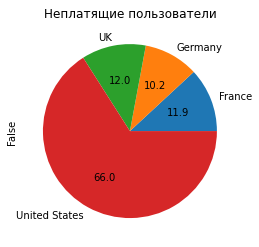

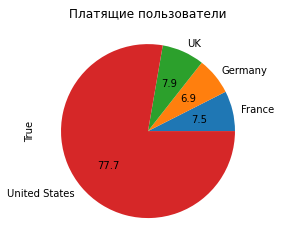

region
France            17450
Germany           14981
UK                17575
United States    100002
Name: user_id, dtype: int64

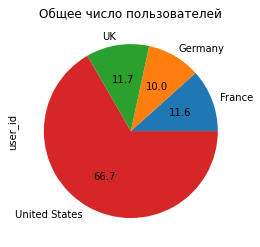

In [ ]:
region_data=data_grouping(profiles,'region')
display(region_data)

plot_data_grouping(profiles,'region')

В приложение приходят клиенты из США, Великобритании, Германии и Франции.

В США больше всего пользователей платящих и неплатящих, 66% и 77.7% соответственно. Пользователей из Великобритании, Германии и Франции примерно одинаковое количество и их примерно в шесть раз меньше, чем пользователей из США.

Во всех странах платящих пользователей очень мало, везде процент неплатящих составляет меньше 5%, кроме Великобритании, где процент платящих примерно равен 6%.

In [ ]:
device_data = data_grouping(profiles,'device')

device_data

payer,non_payer,payer,total,non_payer_percent,payer_percent
device,,,,,
Android,32982,2050,35032,94.148207,5.851793
Mac,28130,1912,30042,93.635577,6.364423
PC,28918,1537,30455,94.953210,5.046790
iPhone,51097,3382,54479,93.792103,6.207897


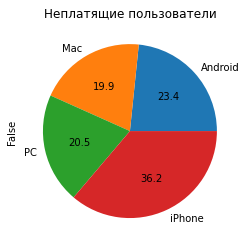

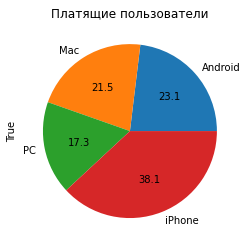

device
Android    35032
Mac        30042
PC         30455
iPhone     54479
Name: user_id, dtype: int64

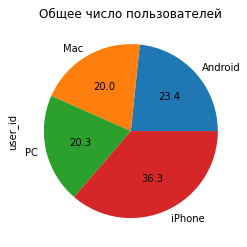

In [ ]:
plot_data_grouping(profiles,'device')

Клиенты пользуются платформами Mac, Android, PC, iPhone.

Клиенты, как платящие, так и неплатящие, пользуются чаще всего Айфонами. Среди всех клиентов, 36.3% пользуются iPhone, среди платящих 38.1 процентов клинетов пользуются iPhone, а среди неплатящих - 36.2%.

Остальными платформами пользуются примерно одинаково, примерно 20% от всех пользователей, а также платящих и неплатящих.

На всех платформах количество платящих пользователей примерно одинаково, но на iPhone и Mac процент платящих клиентов 6.4%, 6.2%, а на Android и PC меньше шести процентов.

payer,non_payer,payer,total,non_payer_percent,payer_percent
channel,,,,,
AdNonSense,3440,440,3880,88.659794,11.340206
FaceBoom,25587,3557,29144,87.795086,12.204914
LeapBob,8291,262,8553,96.936747,3.063253
MediaTornado,4208,156,4364,96.425298,3.574702
OppleCreativeMedia,8372,233,8605,97.292272,2.707728
RocketSuperAds,4096,352,4448,92.086331,7.913669
TipTop,17683,1878,19561,90.399264,9.600736
WahooNetBanner,8100,453,8553,94.703613,5.296387
YRabbit,4147,165,4312,96.173469,3.826531


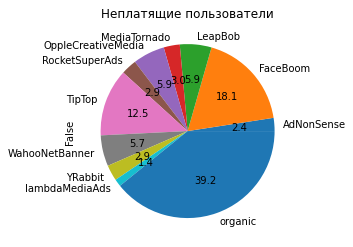

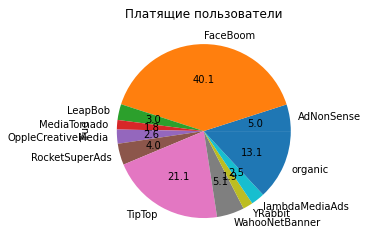

channel
AdNonSense             3880
FaceBoom              29144
LeapBob                8553
MediaTornado           4364
OppleCreativeMedia     8605
RocketSuperAds         4448
TipTop                19561
WahooNetBanner         8553
YRabbit                4312
lambdaMediaAds         2149
organic               56439
Name: user_id, dtype: int64

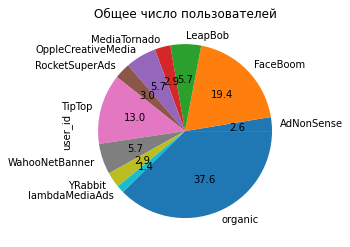

In [ ]:
channel_data = data_grouping(profiles,'channel')
display(channel_data)

plot_data_grouping(profiles,'channel')

Большинство неплатящих пользователей, 39.2%, пришло в приложение естественным путем. Так же выдялются FaceBoom и TipTop, как каналы привлечения, через них пришло 18.1% и 12.5% пользователей соответственно. Через остальные каналы было привлечено менее 6% неплатящих пользователей.

Среди каналов привлечения для платящих пользователей выделяются FaceBoom и TipTop, через них пришло 40.1% и 21.1% соответственно. Естественным путем пришло 13.1%, а через остальные каналы меньше 5%.

Если оценивать по всем пользователям, то большинство пришло естественным путем, 37.6%, а также через FaceBoom и TipTop, 19.4% и 13% соответственно.

Больше всего платящих пользователей пришло из AdNonSense, FaceBoom и lambdaMediaAds: 12.2%, 11.3% и 10.5% соответственно. Через остальные каналы пришло меньше десяти процентов платящих клиентов.

Возможно, если продукт действительно качественный, платящие пользователи могли рассказывать про приложение своим знакомым, и поэтому доля новых пользователей, пришедших естественно, занимает значительную часть. В принципе, это согласуется с тем, что органика больше у неплатящих пользователей.

С одной стороны, большое количество пользователей, пришедших естественно, хорошо тем, что за их привлечение компании не пришлось ничего платить. Но с другой стороны, они сами в большинстве являются неплатящими пользователями, поэтому от них прибыли нет.

# Маркетинг


In [ ]:
costs_info['costs'].sum()

105497.30000000002

channel
AdNonSense             3911.25
FaceBoom              32445.60
LeapBob                1797.60
MediaTornado            954.48
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
TipTop                54751.30
WahooNetBanner         5151.00
YRabbit                 944.22
lambdaMediaAds         1557.60
Name: costs, dtype: float64

<AxesSubplot:xlabel='channel'>

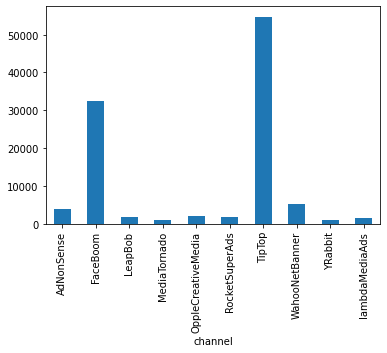

In [ ]:
display(costs_info.groupby('channel')['costs'].sum())

costs_info.groupby('channel')['costs'].sum().plot.bar()

Больше всего было потрачено на рекламу в TipTop, примерно 54000, и FaceBoom, примерно 32400.

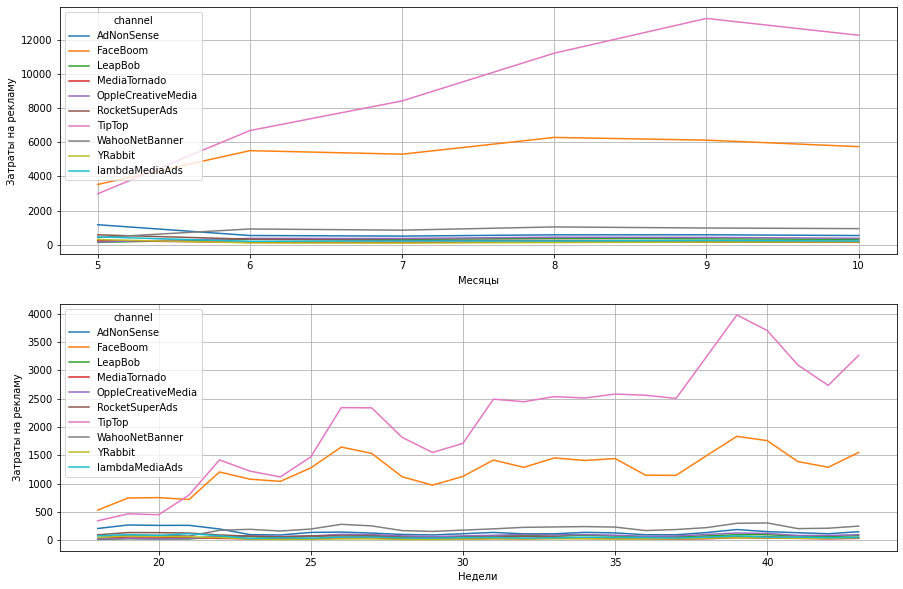

In [ ]:
plt.figure(figsize = (15,10))

ax1 = plt.subplot(2,1,1)
costs_info['month'] = pd.to_datetime(costs_info['dt']).dt.month
costs_info.pivot_table(index='channel',columns=['month'],values='costs',aggfunc='sum').T.plot(grid=True,ax=ax1)
plt.xlabel('Месяцы')
plt.ylabel('Затраты на рекламу')

ax2=plt.subplot(2,1,2)
costs_info['week'] = pd.to_datetime(costs_info['dt']).dt.isocalendar().week
costs_info.pivot_table(index='channel',columns=['week'],values='costs',aggfunc='sum').T.plot(grid=True,ax=ax2)
plt.xlabel('Недели')
plt.ylabel('Затраты на рекламу')


plt.show()

Средства выделялись неравномерно в течение рассматриваемого времени, если рассматривать разбиение по неделям.

Больше всего средств было направлено на рекламу в FaceBoom и TipTop, на остальные средств было выделено много меньше.

Расходы на TipTop и FaceBoom сильно менялись за рассматриваемый период, видны большие провалы в на 35-ой и 40-ой неделях.

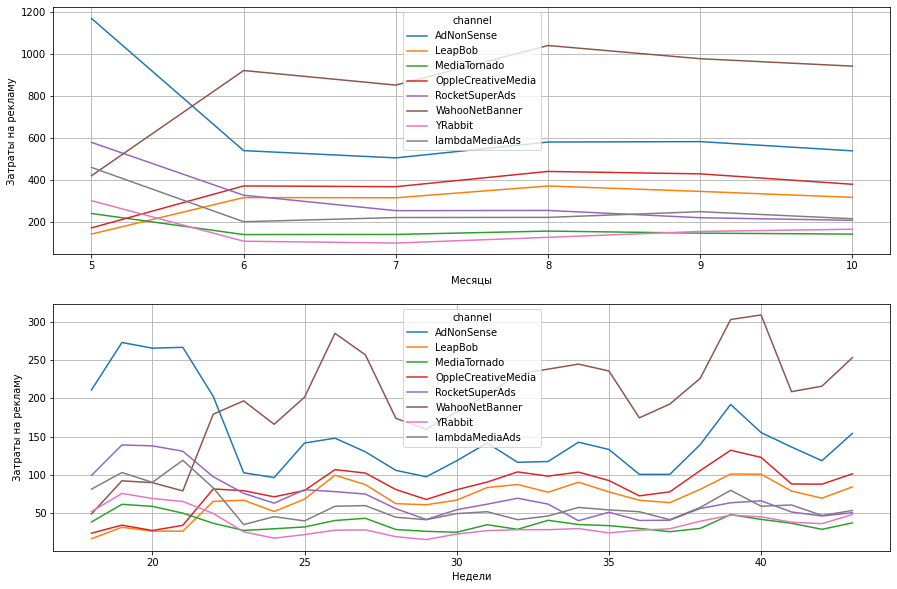

In [ ]:
plt.figure(figsize = (15,10))

ax1 = plt.subplot(2,1,1)
costs_info['month'] = pd.to_datetime(costs_info['dt']).dt.month
costs_info.pivot_table(index='channel',columns=['month'],values='costs',aggfunc='sum').\
query('channel!="TipTop"&channel!="FaceBoom"').T.plot(grid=True,ax=ax1)
plt.xlabel('Месяцы')
plt.ylabel('Затраты на рекламу')

ax2=plt.subplot(2,1,2)
costs_info['week'] = pd.to_datetime(costs_info['dt']).dt.isocalendar().week
costs_info.pivot_table(index='channel',columns=['week'],values='costs',aggfunc='sum').\
query('channel!="TipTop"&channel!="FaceBoom"').T.plot(grid=True,ax=ax2)
plt.xlabel('Недели')
plt.ylabel('Затраты на рекламу')


plt.show()

Траты по всем остальным каналам, кроме TipTop и FaceBoom, одного порядка. Из всех выделяется WahooNetBanner и AdNonSense, на них тратилось больше всего денег. Меньше всего - на MediaTornado и YRabbit.

Если рассматривать еженедельные траты, то также видно, что траты распределены неравномерно.

channel
AdNonSense            1.008054
FaceBoom              1.113286
LeapBob               0.210172
MediaTornado          0.218717
OppleCreativeMedia    0.250000
RocketSuperAds        0.412095
TipTop                2.799003
WahooNetBanner        0.602245
YRabbit               0.218975
lambdaMediaAds        0.724802
organic               0.000000
Name: acquisition_cost, dtype: float64

Среднее значение CAC по всему проекту 0.7032778251826568


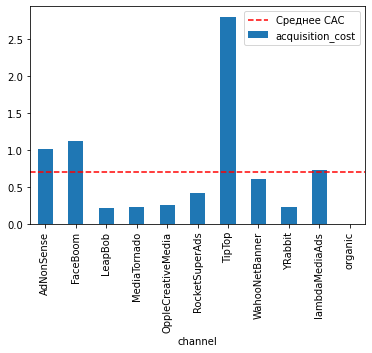

In [ ]:
display(profiles.groupby('channel')['acquisition_cost'].mean())

print('Среднее значение CAC по всему проекту',profiles['acquisition_cost'].mean())

profiles.groupby('channel')['acquisition_cost'].mean().plot.bar()
plt.axhline(y=profiles['acquisition_cost'].mean(), color='red', linestyle='--', label='Среднее CAC')
plt.legend()
plt.show()

Средняя стоимость привлечения одного пользователя выделяется у канала TipTop - примерно 2.8, что почти в четыре раза больше среднего значения CAC по всем данным. У FaceBoom и AdNonSense - примерно 1, у остальных - не больше 0.7.

### Оценка окупаемости рекламы


In [ ]:
profiles_filtered = profiles.query('channel!="organic"')
user_id_array = profiles_filtered['user_id'].unique()

visits_info_filtered = visits_info.query('channel!="organic"')

orders_info_filtered = orders_info.query('user_id in @user_id_array')


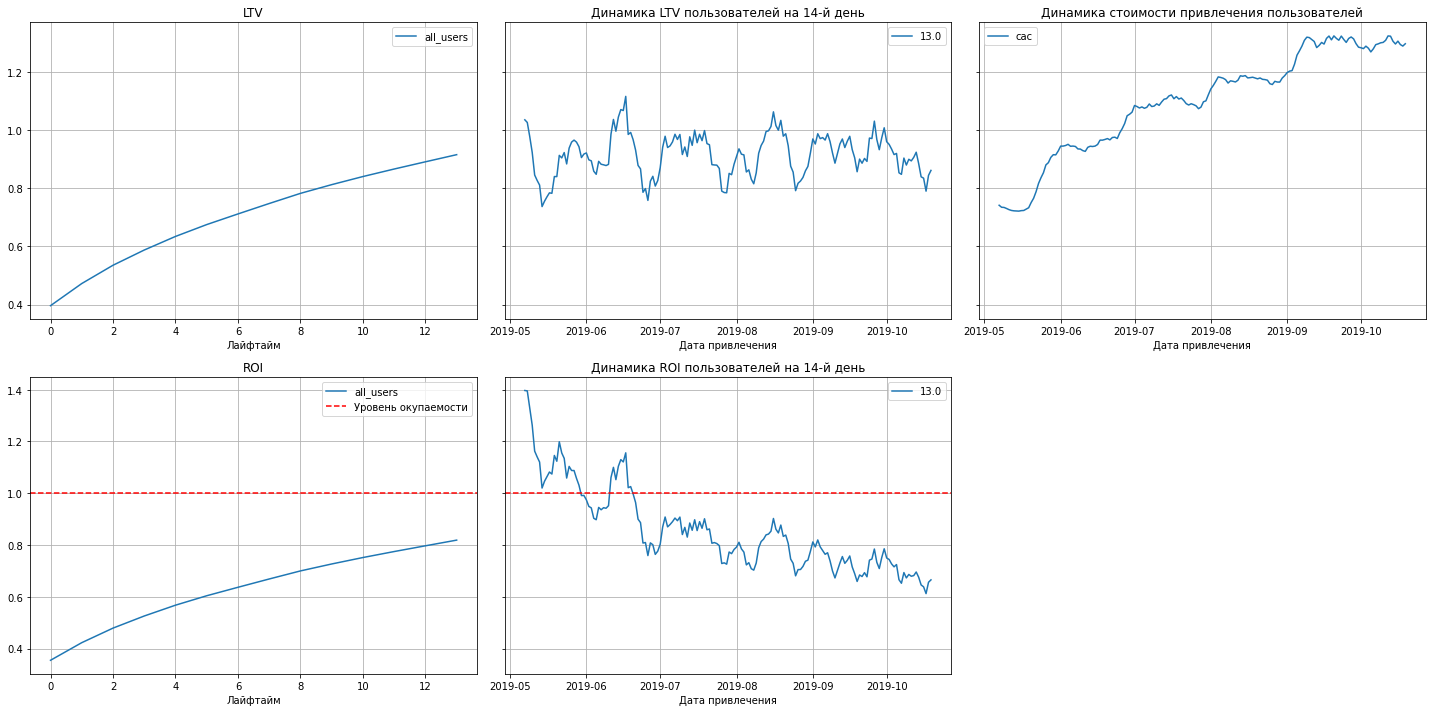

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_filtered,orders_info_filtered,datetime(2019,11,1).date(),14)

plot_ltv_roi(ltv_grouped,ltv_history,roi_grouped,roi_history,14)

Инвестиции не окупаются, только к концу второй недели ROI вышел на 0,8. Стоимость привлечения одного покупателя росла постепенно весь исследуемый период. LTV периодически убывает и возрастает, но в среднем меняется не сильно. ROI падает и в июне инвестиции перестали окупаться.

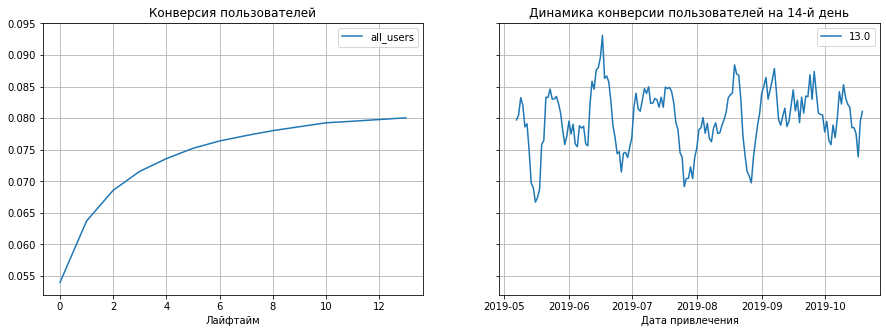

In [ ]:
conversion_raw, conversion, conversion_history = get_conversion(profiles_filtered,orders_info_filtered,datetime(2019,11,1).date(),14)

plot_conversion(conversion,conversion_history,14,window=7)

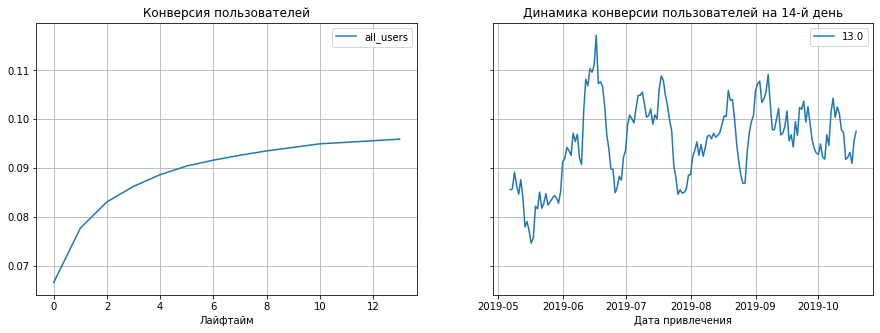

In [ ]:
conversion_raw, conversion, conversion_history = get_conversion(profiles_filtered.query('region=="United States"'),orders_info_filtered,datetime(2019,11,1).date(),14)

plot_conversion(conversion,conversion_history,14,window=7)

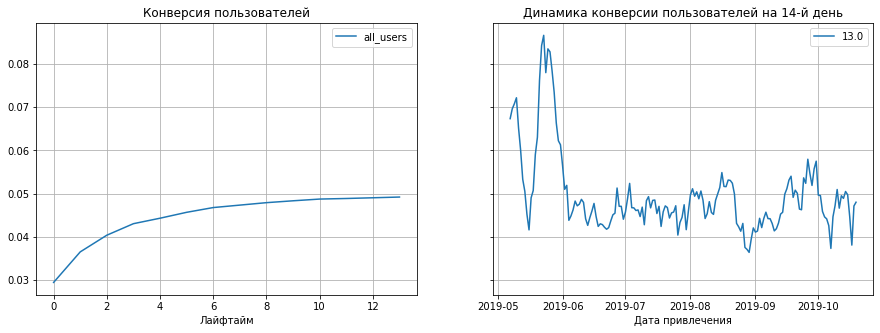

In [ ]:
conversion_raw, conversion, conversion_history = get_conversion(profiles_filtered.query('region!="United States"'),orders_info_filtered,datetime(2019,11,1).date(),14)

plot_conversion(conversion,conversion_history,14,window=7)

Конверсия небольшая, примерно восемь процентов пользователей конвертируются в платящих.

Динамика конверсии колебалась в районе восьми процентов все время наблюдения.


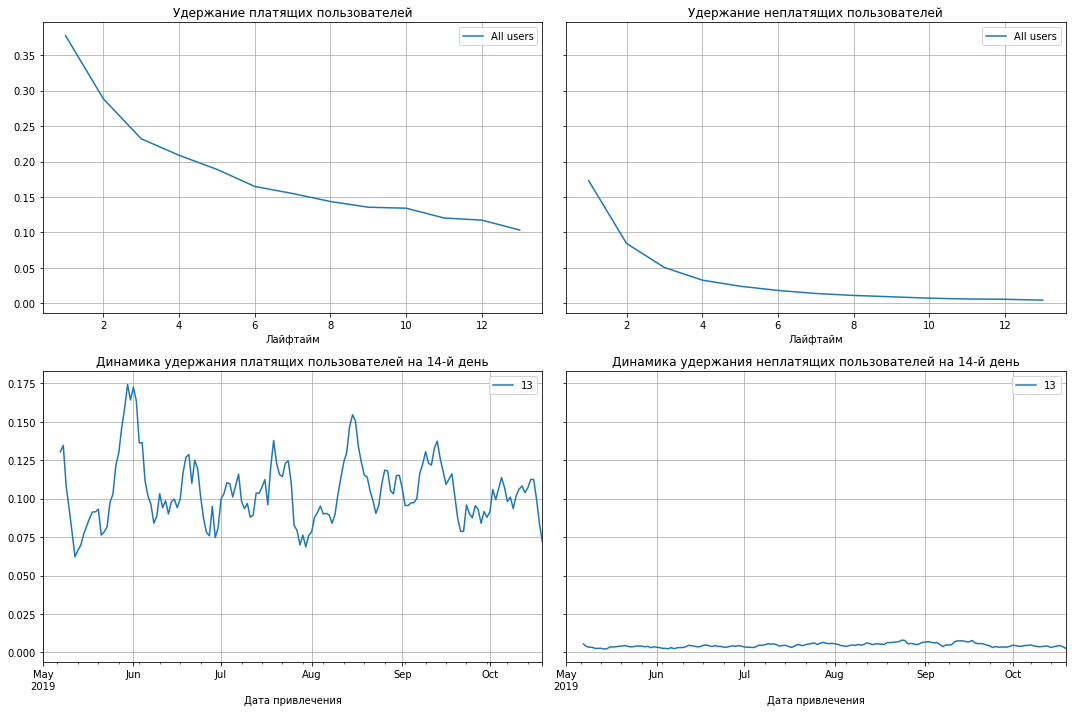

In [ ]:
retention_raw, retention, retention_history = get_retention(profiles_filtered, visits_info_filtered, datetime(2019,11,1).date(),14)

plot_retention(retention, retention_history,14)

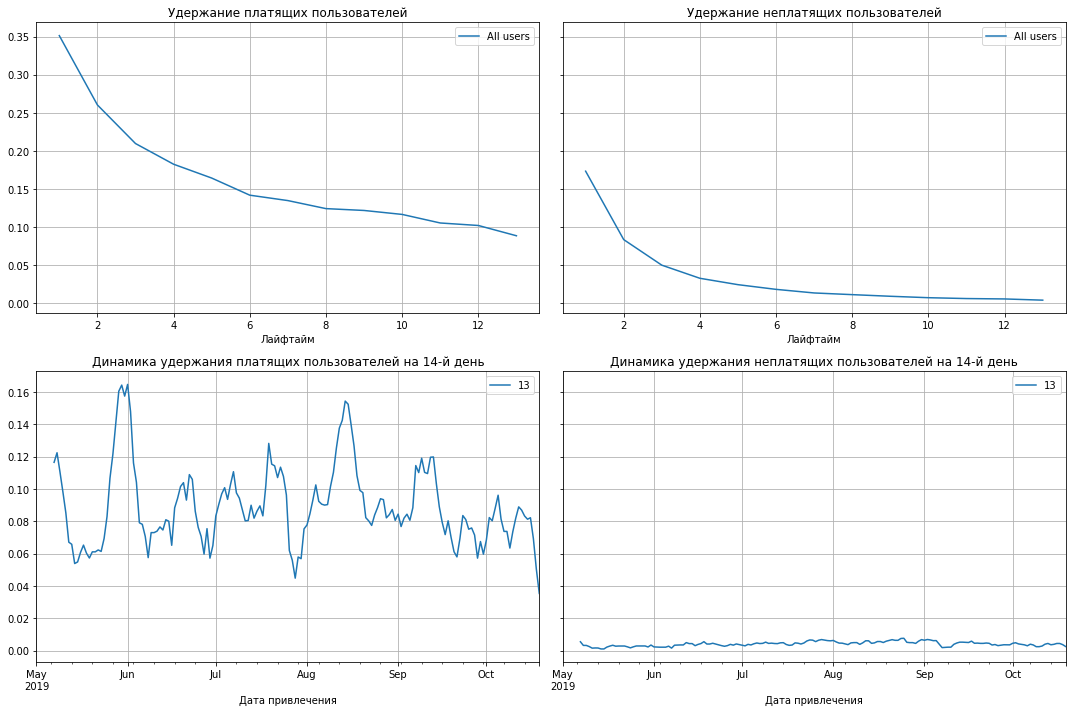

In [ ]:
retention_raw, retention, retention_history = get_retention(profiles_filtered.query('region=="United States"'), visits_info_filtered, datetime(2019,11,1).date(),14)

plot_retention(retention, retention_history,14)

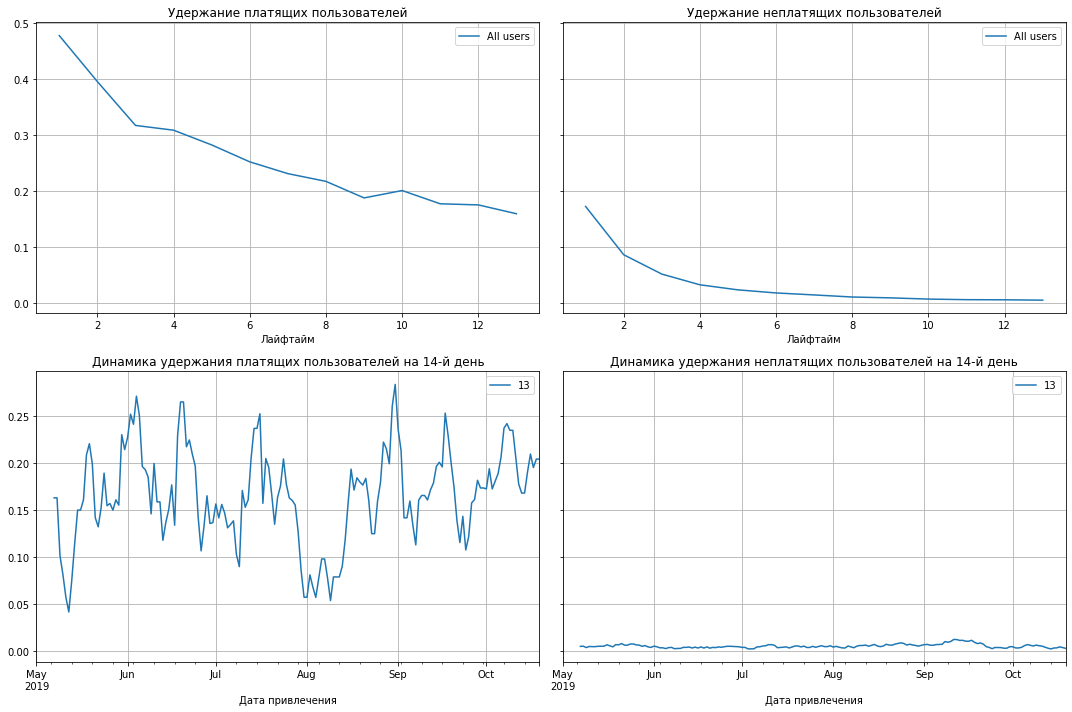

In [ ]:
retention_raw, retention, retention_history = get_retention(profiles_filtered.query('region!="United States"'), visits_info_filtered, datetime(2019,11,1).date(),14)

plot_retention(retention, retention_history,14)

Коэффициент удержания для платящих пользователей небольшой, в начале он равен примерно 0.35, к концу рассматриваемого периода падает до примерно 0.1. Для неплатящих пользователей коэффициент удержания падает с меньше, чем 0.2 до почти нуля.

Удержание колебалось на протяжении всего времени около 0.1 для платящих пользователей. Для неплатящих пользователей удержание оставалось неизменным, было близко к нулю.

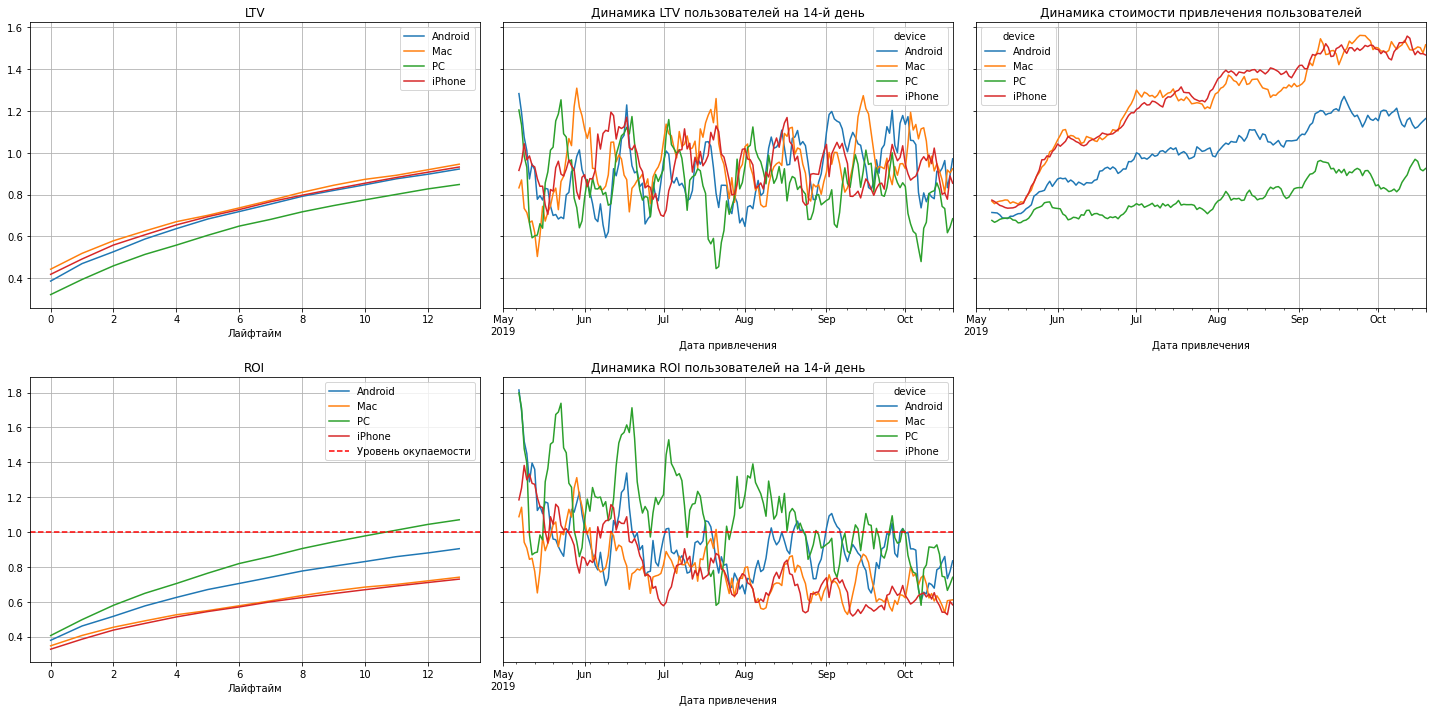

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_filtered,orders_info_filtered,\
                                                                      datetime(2019,11,1).date(),14,dimensions=['device'])

plot_ltv_roi(ltv_grouped,ltv_history,roi_grouped,roi_history,14)

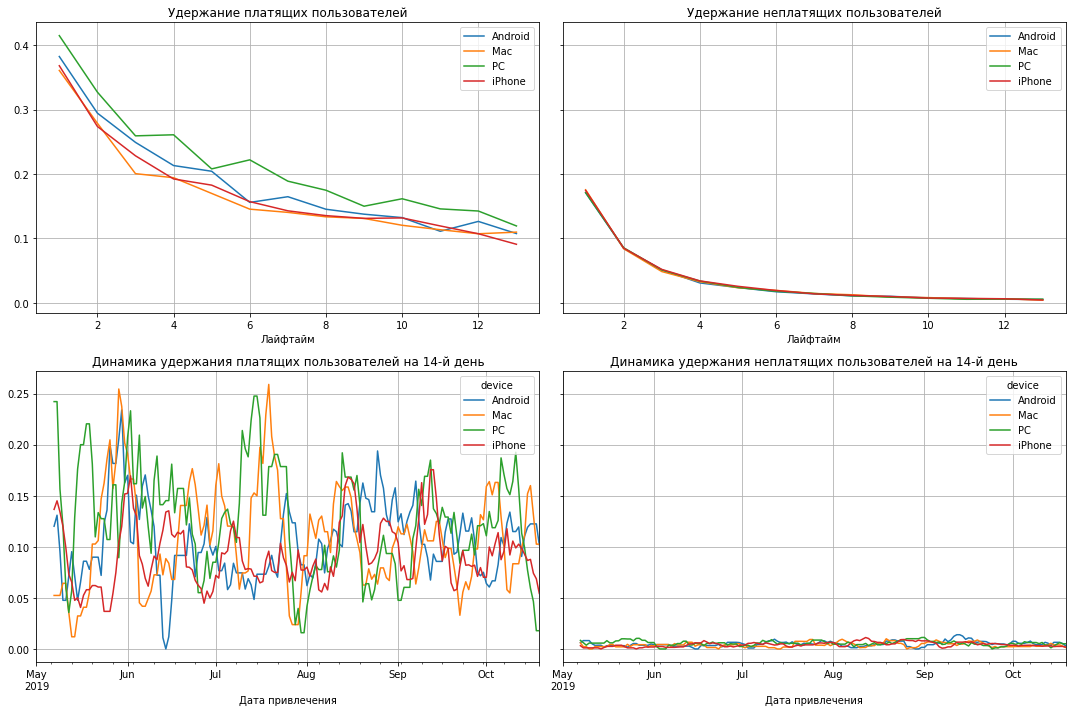

In [ ]:
retention_raw, retention, retention_history = get_retention(profiles_filtered, visits_info_filtered, datetime(2019,11,1).date(),14,\
                                                            dimensions=['device'])

plot_retention(retention, retention_history,14)

LTV для всех платформ примерно одинаков, однако для PC немного меньше. Для всех платформ стабилен, хотя для PC периодически проседает.

Реклама плохо окупается, только к концу лайфтайма для пользователей на PC она начинает окупаться. Для всех остальных платформ ROI меньше единицы. Со временем окупаемость падает, и почти все платформы, которые окупались в начале изучаемого периода, перестали окупаться в конце. Лучше всего окупается PC, хуже всего - Mac и iPhone.

Стоимость привлечения платящих клиентов росла все время, причем стоимость клиентов на Mac и iPhone заметно больше, и для этих платформ она сравнима. Меньше всего стоят клиенты на PC.

Удержание для всех платформ почти одинаково, хотя для PC немного больше, чем для остальных.

Для неплатящих клиентов удержание для всех платформ близко к нулю.

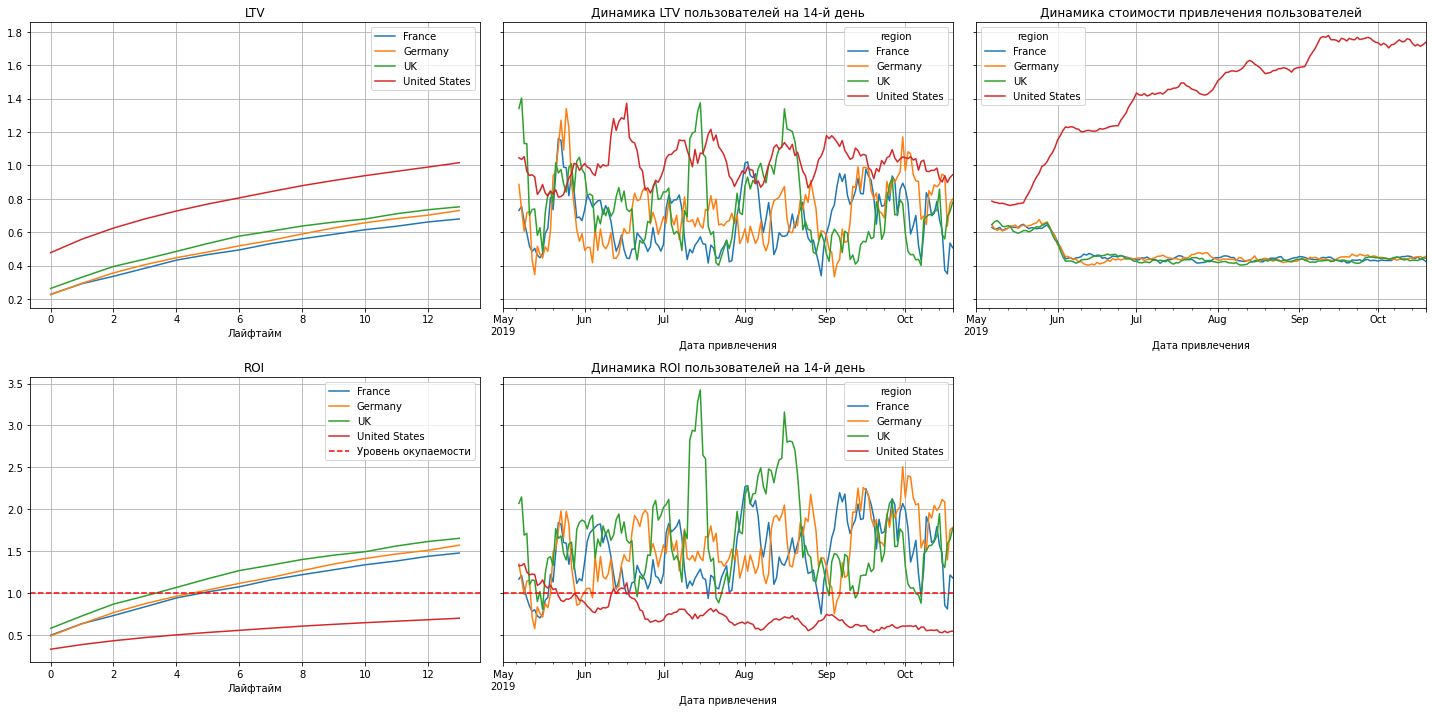

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_filtered,orders_info_filtered,datetime(2019,11,1).date(),\
                                                                      14,dimensions=['region'])

plot_ltv_roi(ltv_grouped,ltv_history,roi_grouped,roi_history,14)

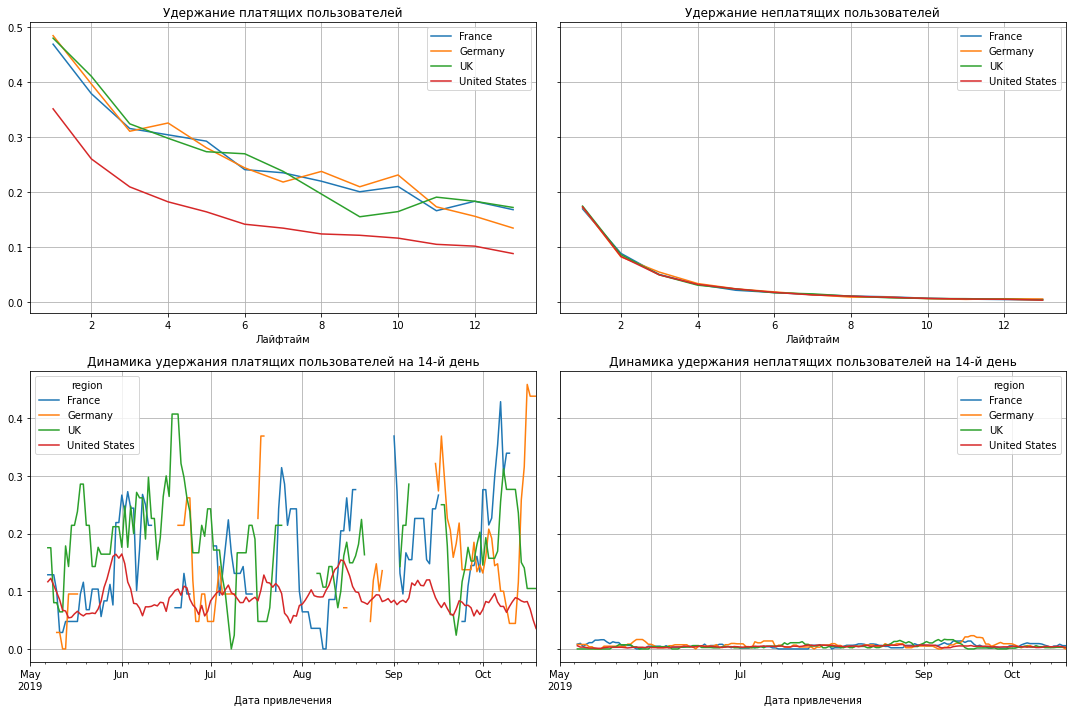

In [ ]:
retention_raw, retention, retention_history = get_retention(profiles_filtered, visits_info_filtered, datetime(2019,11,1).date(),14,\
                                                            dimensions=['region'])

plot_retention(retention, retention_history,14)

LTV для США намного больше LTV для остальных стран, к концу лайфтайма он достиг 1, а для остальных - примерно 0.8. LTV для остальных стран примерно на одном уровне. На протяжении всего периода LTV в США лидировал.

CAC для США намного выше, чем для остальных стран, причем в июне был резкий скачок и CAC рос до примерно 1.8. При этом для других стран CAC, наоборот, упала в июне с 0.6 до 0.4 и до конца рассматриваемого периода не менялась.

Реклама не окупается только в США. Также там коэффициент окупаемости падал все время, в то время, как в остальных странах был стабилен.

Удерживаются хуже всего пользователи из США.

Судя по низкому коэффициенту удержания в США, а также высокой стоимости привлечения клиентов, приложение в США не пользуется популярностью. Возможно, по каким-то техническим причинам в Америке оно не имеет успеха, поэтому следует ввести какие-то коррективы в функционал, чтобы привлечь больше пользователей из этого региона. Либо тратить меньше средств на рекламу в США.

region         device 
France         Android     5252
               Mac         1838
               PC          6940
               iPhone      3420
Germany        Android     4440
               Mac         1584
               PC          5945
               iPhone      3012
UK             Android     5141
               Mac         1778
               PC          7138
               iPhone      3518
United States  Android    20199
               Mac        24842
               PC         10432
               iPhone     44529
Name: user_id, dtype: int64

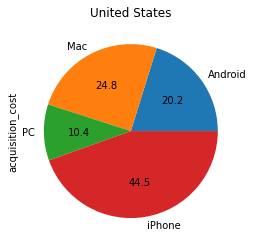

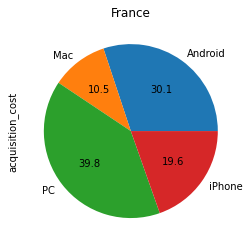

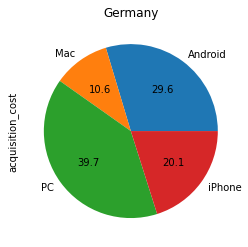

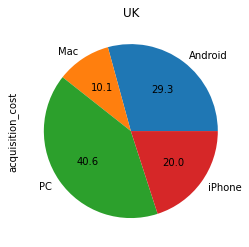

In [ ]:
display(profiles.pivot_table(index=['region','device'],aggfunc='count')['user_id'])

for region in (profiles['region'].unique()):
    profiles.query('region==@region').pivot_table(index='device',aggfunc='count')['acquisition_cost']\
    .plot.pie(autopct='%.1f')
    plt.title(region)
    plt.show()

Платформами iPhone и Mac больше всего пользуются в США: 44.5% пользуются iPhone и 24.8% - Mac. В остальных странах больше всего пользуются Android и PC.

Также в клиентов из США намного больше, чем пользователей из других стран.

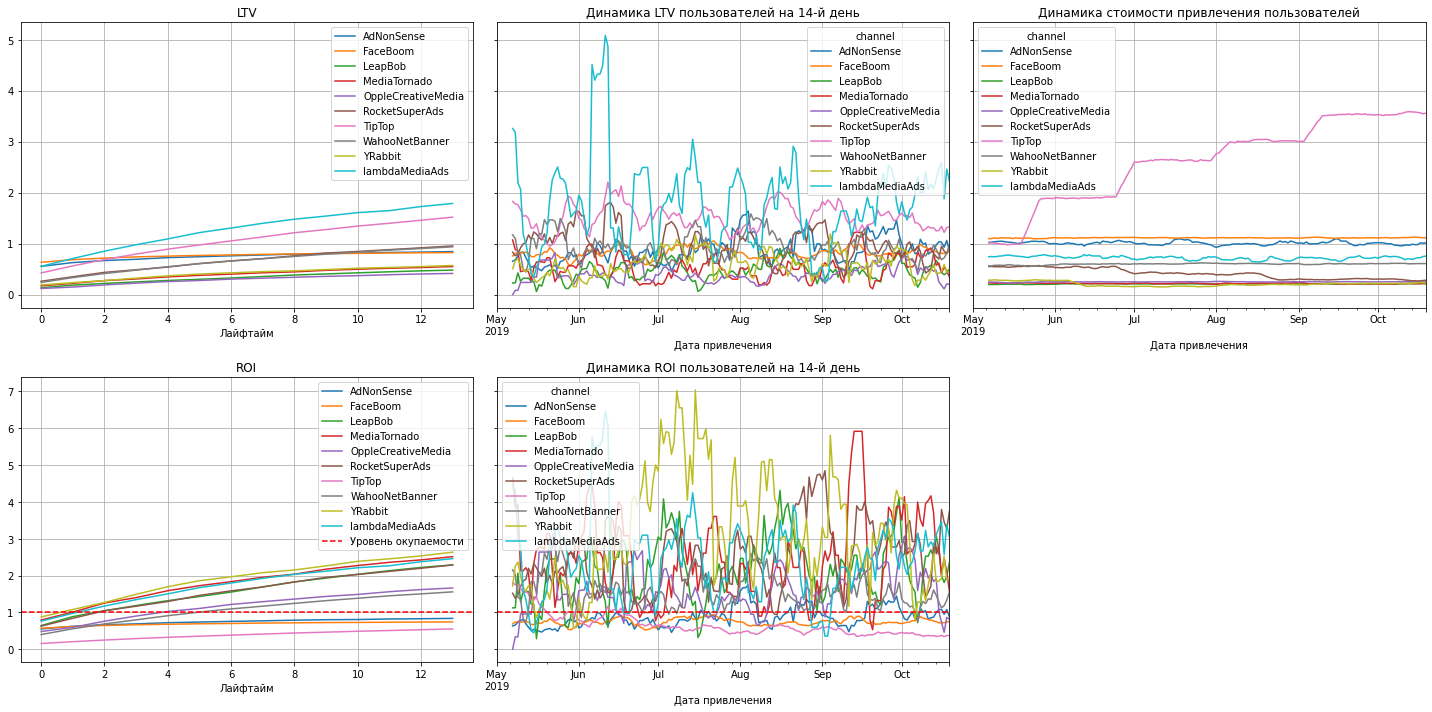

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_filtered,orders_info,datetime(2019,11,1).date(),14,dimensions=['channel'])

plot_ltv_roi(ltv_grouped,ltv_history,roi_grouped,roi_history,14)

Среди каналов привлечения выделяются lambdaMediaAds и TipTop, для них "пожизненная ценность" клиента наиболее высокая.

Для всех каналов привлечения, кроме TipTop, CAC стабилен. Однако в конце каждого месяца стоимость привлечения для TipTop растет, после чего не меняется до конца данного месяца.

Реклама не окупается для TipTop, FaceBoom и AdNonSense, для всех остальных окупается. ROI для большинства каналов не менялся со временем, однако для YRabbit ROI достиг максимума в период между июлем и августом, также у MediaTornado есть заметный пик в сентябре.

Реклама, вообще говоря, не окупается. Не окупается реклама для пользователей на Mac, iPhone из США, пришедших из TipTop, FaceBoom и AdNonSense.

Стоимость привлечения пользователей на iPhone и Mac много выше стоимости привлечения остальных клиентов.

Так как среди всех рассматриваемых стран выделяется США, как страна, в которой хуже всего окупается реклама, можно предположить, что это происходит из-за маленьких значений удержания и конверсии в принципе, а так же из-за большого количества пользователей из США. Поэтому стоит как-то увеличить количество клиентов, которые конвертируются в платящих, а также увеличить показатель удержания. Например, изменить функционал, сделать так, чтобы сделать покупку было легче.


In [ ]:
profiles_filtered.query('device=="iPhone"|device=="Mac"').groupby('month')['user_id'].count()

month
2019-05-01    7066
2019-06-01    8577
2019-07-01    8376
2019-08-01    9759
2019-09-01    9733
2019-10-01    9064
Name: user_id, dtype: int64

In [ ]:
visits_info_filtered['session_length'] = ((visits_info_filtered['session_end']) -\
                                              (visits_info_filtered['session_start'])).dt.total_seconds()

short_sessions = visits_info_filtered.query('session_length<90').groupby(['region','device'])['session_length'].count()
short_sessions_perc = visits_info_filtered.query('session_length<90').groupby(['region','device'])['session_length'].count()*100 \
/visits_info_filtered.groupby(['region'])['session_length'].count()

df=pd.concat([short_sessions,short_sessions_perc],axis=1)
df

/tmp/ipykernel_82/2021149893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits_info_filtered['session_length'] = ((visits_info_filtered['session_end']) -\


session_length  session_length
region        device                                 
France        Android             346        1.482942
              Mac                 124        0.531459
              PC                  490        2.100120
              iPhone              219        0.938625
Germany       Android             295        1.457510
              Mac                 102        0.503953
              PC                  427        2.109684
              iPhone              207        1.022727
UK            Android             316        1.311312
              Mac                 108        0.448170
              PC                  459        1.904722
              iPhone              233        0.966885
United States Android            1327        0.986830
              Mac                1614        1.200259
              PC                  642        0.477426
              iPhone             2866        2.131315

Количество слишком коротких сессий больше всего для Америки для всех платформ. Однако относительно всех сессий Америка на выделяется на фоне других стран.

In [ ]:
costs_info.query('channel=="TipTop"').groupby('month')['costs'].mean()

month
5      96.161290
6     222.520000
7     271.296774
8     361.354839
9     441.083333
10    453.703704
Name: costs, dtype: float64

<AxesSubplot:ylabel='costs'>

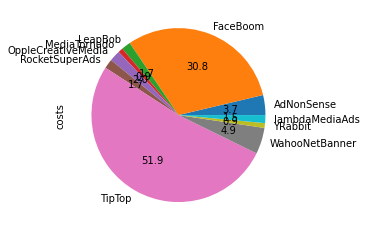

In [ ]:
costs_info.groupby('channel')['costs'].sum().plot.pie(autopct='%.1f')

Траты на рекламу в TipTop росли с каждым месяцем, что частично подтверждает последнюю гипотезу. Также можно видеть огромную разницу в привлечении средств для разных каналов. В TipTop было вложено больше половины всех средств.

Чтобы сделать рекламу более эффективной стоит тратить меньше средств на продвижение в TipTop и вложить больше денег на другой канал. Например, на lambdaMediaAds, так как у него высокий ROI, LTV и CAC.

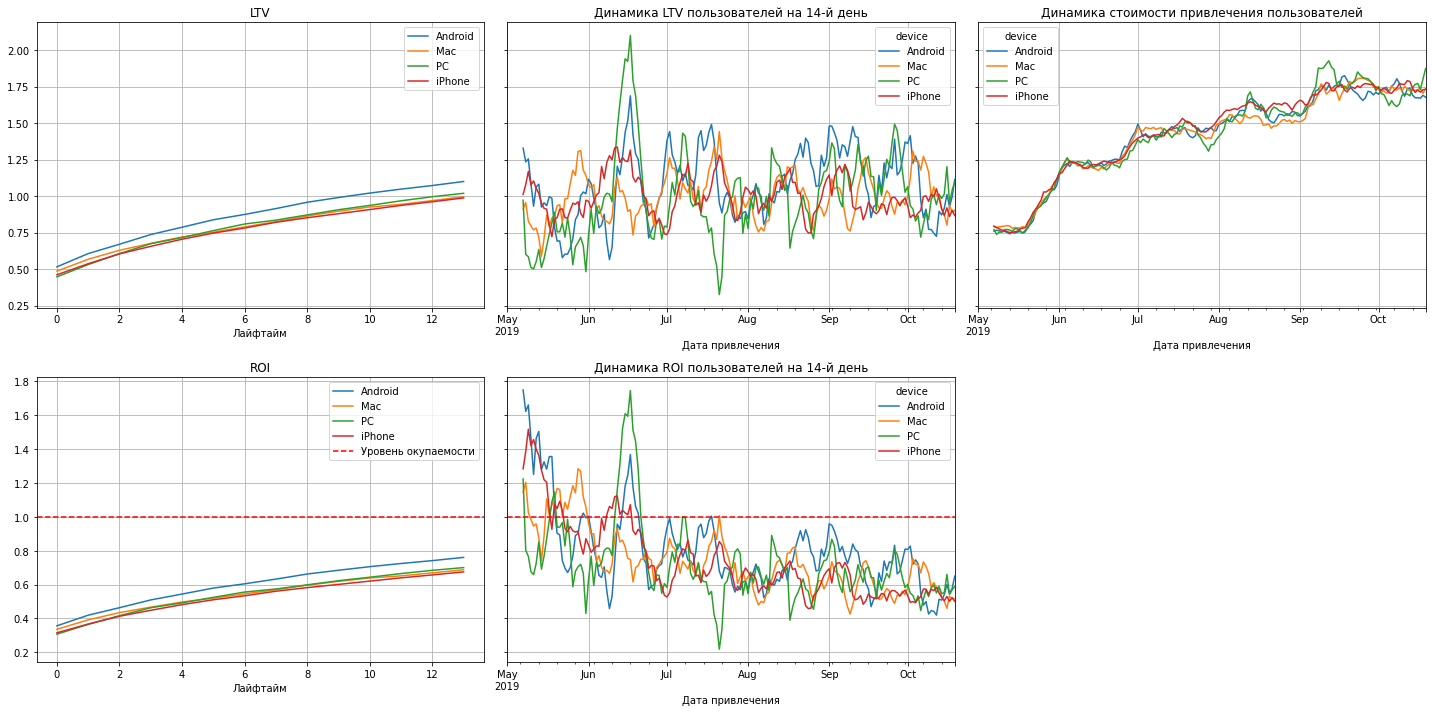

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_filtered.query('region=="United States"'),orders_info_filtered,\
                                                                      datetime(2019,11,1).date(),14,dimensions=['device'])

plot_ltv_roi(ltv_grouped,ltv_history,roi_grouped,roi_history,14)

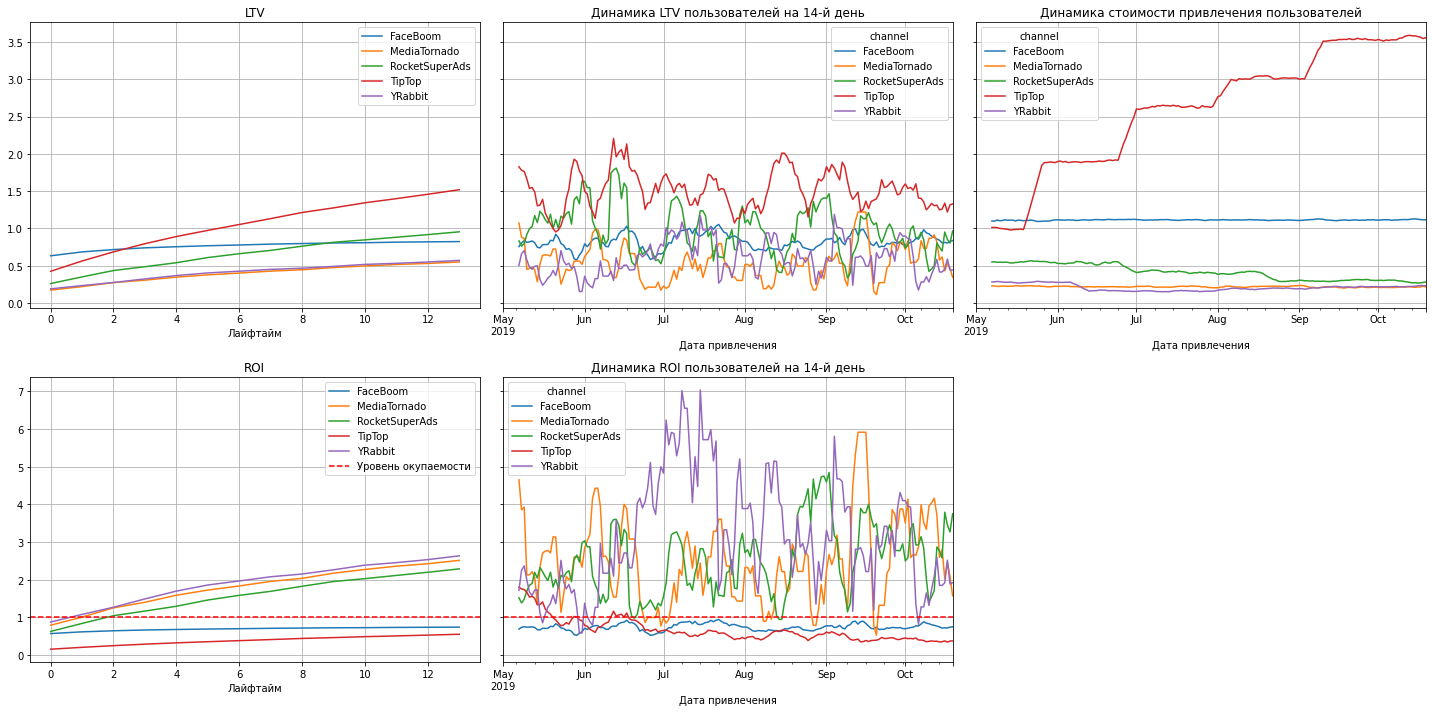

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_filtered.query('region=="United States"'),orders_info_filtered,\
                                                                      datetime(2019,11,1).date(),14,dimensions=['channel'])

plot_ltv_roi(ltv_grouped,ltv_history,roi_grouped,roi_history,14)

Бизнес-показатели для США показывают, что ни одна платформа не окупается и стоимость привлечения пользователей растет для всех платформ. Также не окупаются TipTop и FaceBoom, как каналы привлечения.

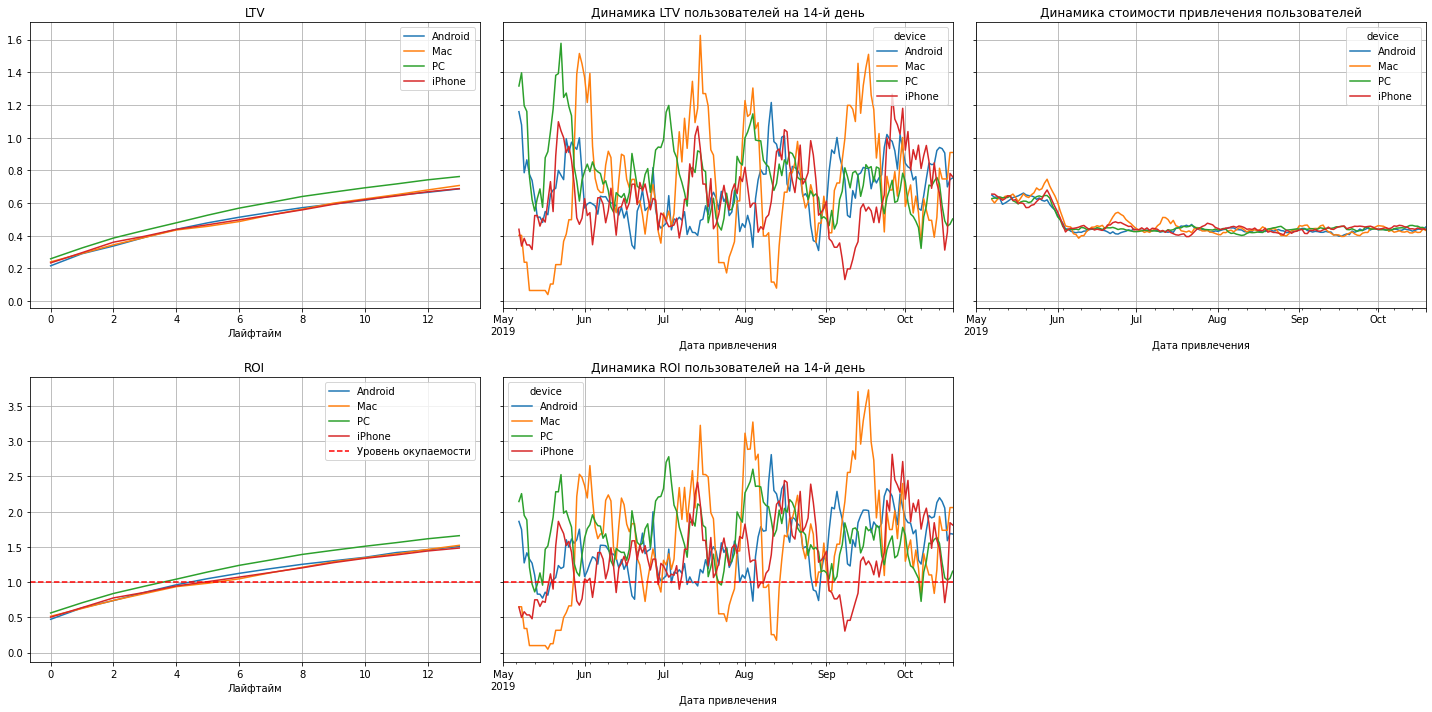

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_filtered.query('region!="United States"'),orders_info_filtered,\
                                                                      datetime(2019,11,1).date(),14,dimensions=['device'])

plot_ltv_roi(ltv_grouped,ltv_history,roi_grouped,roi_history,14)

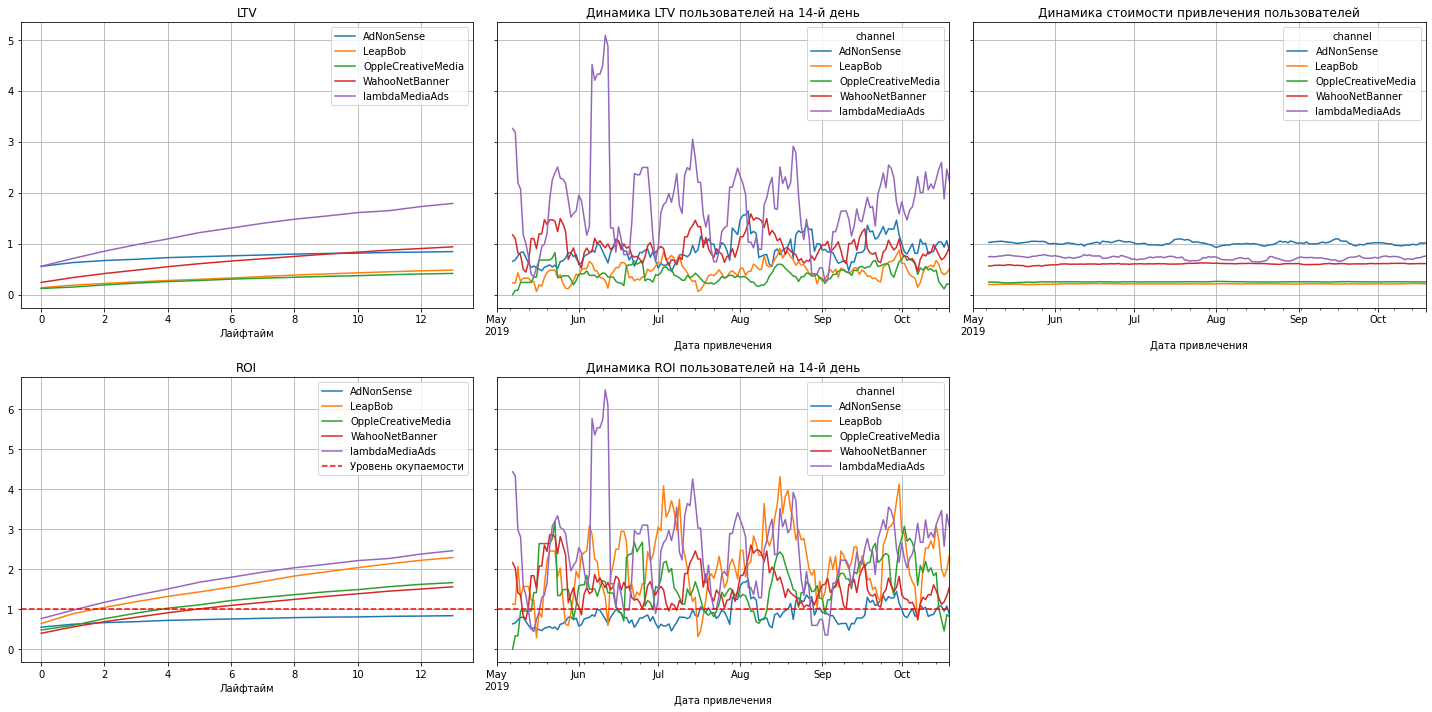

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_filtered.\
                                                                      query('region!="United States"'),orders_info_filtered,\
                                                                      datetime(2019,11,1).date(),14,dimensions=['channel'])

plot_ltv_roi(ltv_grouped,ltv_history,roi_grouped,roi_history,14)

В Европе же все выглядит гораздо лучше: инвестиции окупаются для всех платформ и стоимость привлечения пользователей в июне упала и не менялась. Что касается каналов привлечения, не окупается только AdNonSense.

### Выводы

В ходе исследования были изучены данные о посещениях сайта, заказах и тратах на рекламу. Были получены следующие результаты:

 - Больше всего пользователей, как платящих, так и неплатящих из США
 - Больше всего пользователей пользуются iPhone, причем в США доля пользователей iPhone и Mac больше остальных стран
 - Большинство неплатящих пользователей узнало о приложении естественным путем, а большинство платящих - из lambdaMediaAds, FaceBoom и TipTop
 - Больше 90% пользователей являются неплатящими
 - Инвестиции в США не окупаются, так же CAC там все время возрастала.
 - Конверсия небольшая,примерно восемь процентов пользователей конвертируются в платящих.
 - Коэффициент удержания для платящих пользователей примерно 0.35, к концу рассматриваемого периода падает до 0.1. Для неплатящих пользователей коэффициент удержания падает с меньше, чем 0.2 до почти нуля.
 - Для США реклама не окупается для всех платформ, FaceBoom и TipTop тоже не окупаются.


Компания терпит убытки на рекламе скорее всего из-за того, что пользователей из США очень много, при этом доля платящих клиентов очень мала, следовательно большинство пользователей не приносят денег. Для того, чтобы решить проблему, во-первых, вероятно стоит пересмотреть планы расходов на рекламу. На некоторые каналы привлечения, как TipTop и FaceBoom, уходит гораздо больше денег, чем на остальные, хотя даже естественным путем приходит достаточно много пользователей, а из lambdaMediaAds приходит немного клиентов. Поэтому можно было бы перенаправить вложения в YRabbit, RocketSuperAds и MediaTornado, поскольку они имеют успех в США, где находится большая часть клиентов. Возможно, стоит отказаться от инвестиций в lambdaMediaAds.

И во-вторых, стоит внести какие-то изменения в приложение, чтобы больше пользователей конвертировалось в платящих. Может, стоит ограничить функционал для неплатящих пользователей, может, добавить что-то, что было бы доступно только платящим пользователям. Только больше клиентов будут платить, следовательно вырастет прибыль и реклама начнет окупаться.